In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pylab as plt
import seaborn as sn
import numpy as np

In [3]:
df = pd.read_csv("data/sp500/csv/AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')

### Visual Stationarity

In [5]:
half = int(len(df) / 2)
first_half = df['Close'].iloc[:half]
second_half = df['Close'].iloc[half:]

# Calculate rolling statistics
window_size = 12 
first_half_rolling_mean = first_half.rolling(window=window_size).mean()
first_half_rolling_std = first_half.rolling(window=window_size).std()

second_half_rolling_mean = second_half.rolling(window=window_size).mean()
second_half_rolling_std = second_half.rolling(window=window_size).std()

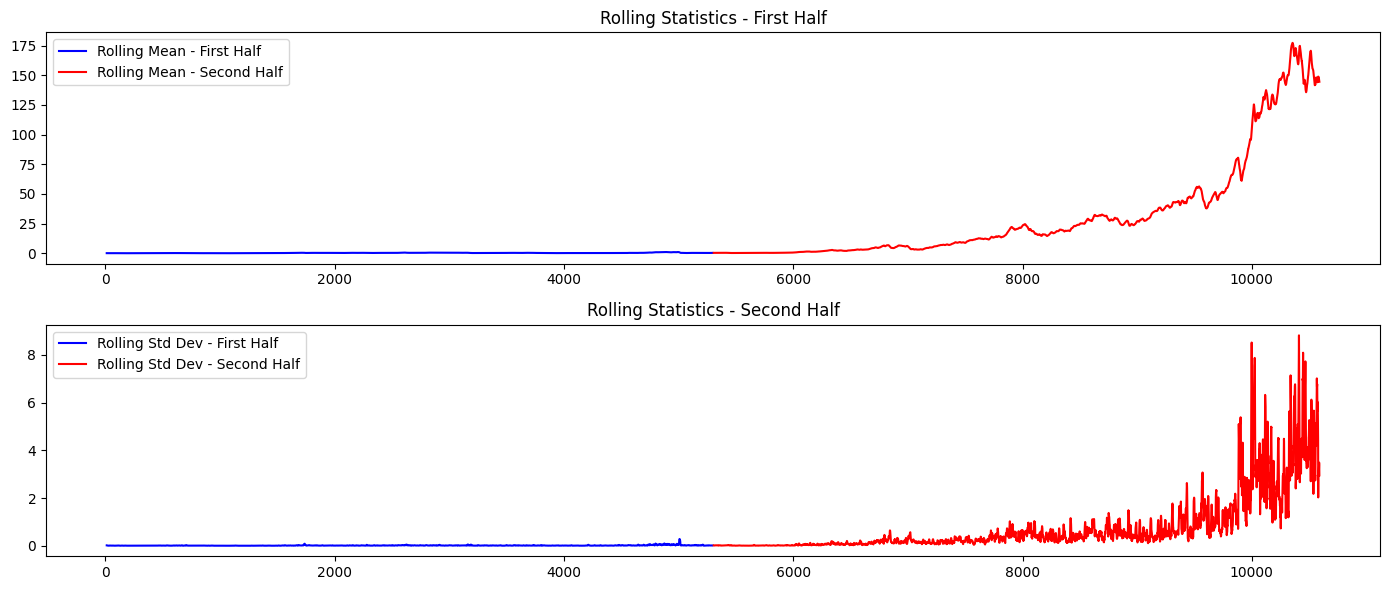

In [6]:
import matplotlib.pyplot as plt

# Plot Rolling Statistics for the First Half
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(first_half_rolling_mean, label='Rolling Mean - First Half', color='blue')
plt.plot(second_half_rolling_mean, label='Rolling Mean - Second Half', color='red')
plt.title('Rolling Statistics - First Half')
plt.legend()

# Plot Rolling Statistics for the Second Half
plt.subplot(2, 1, 2)
plt.plot(first_half_rolling_std, label='Rolling Std Dev - First Half', color='blue')
plt.plot(second_half_rolling_std, label='Rolling Std Dev - Second Half', color='red')
plt.title('Rolling Statistics - Second Half')
plt.legend()

plt.tight_layout()
plt.show()

### Statistical Stationarity

In [7]:
close_prices = df['Close']

In [8]:
result = adfuller(close_prices.dropna()) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.301392
p-value: 0.998956
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [9]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Num Lags: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(close_prices)


KPSS Statistic: 7.9526701498163845
p-value: 0.01
Num Lags: 60
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/var/folders/fb/7_4yf_c520g4241wpnlcdznh0000gn/T/ipykernel_11866/3698218819.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


### Make the series Stationary

In [10]:
df["close_diff"] = df["Close"].diff()

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit a linear model
X = np.arange(len(df)).reshape(-1, 1)
y = df["Close"].values
model = LinearRegression()
model.fit(X, y)

# Calculate the trend
trend = model.predict(X)

# Detrend the series
df["close_detrend"] = y - trend

In [12]:
df["close_log"] = np.log(df["Close"])

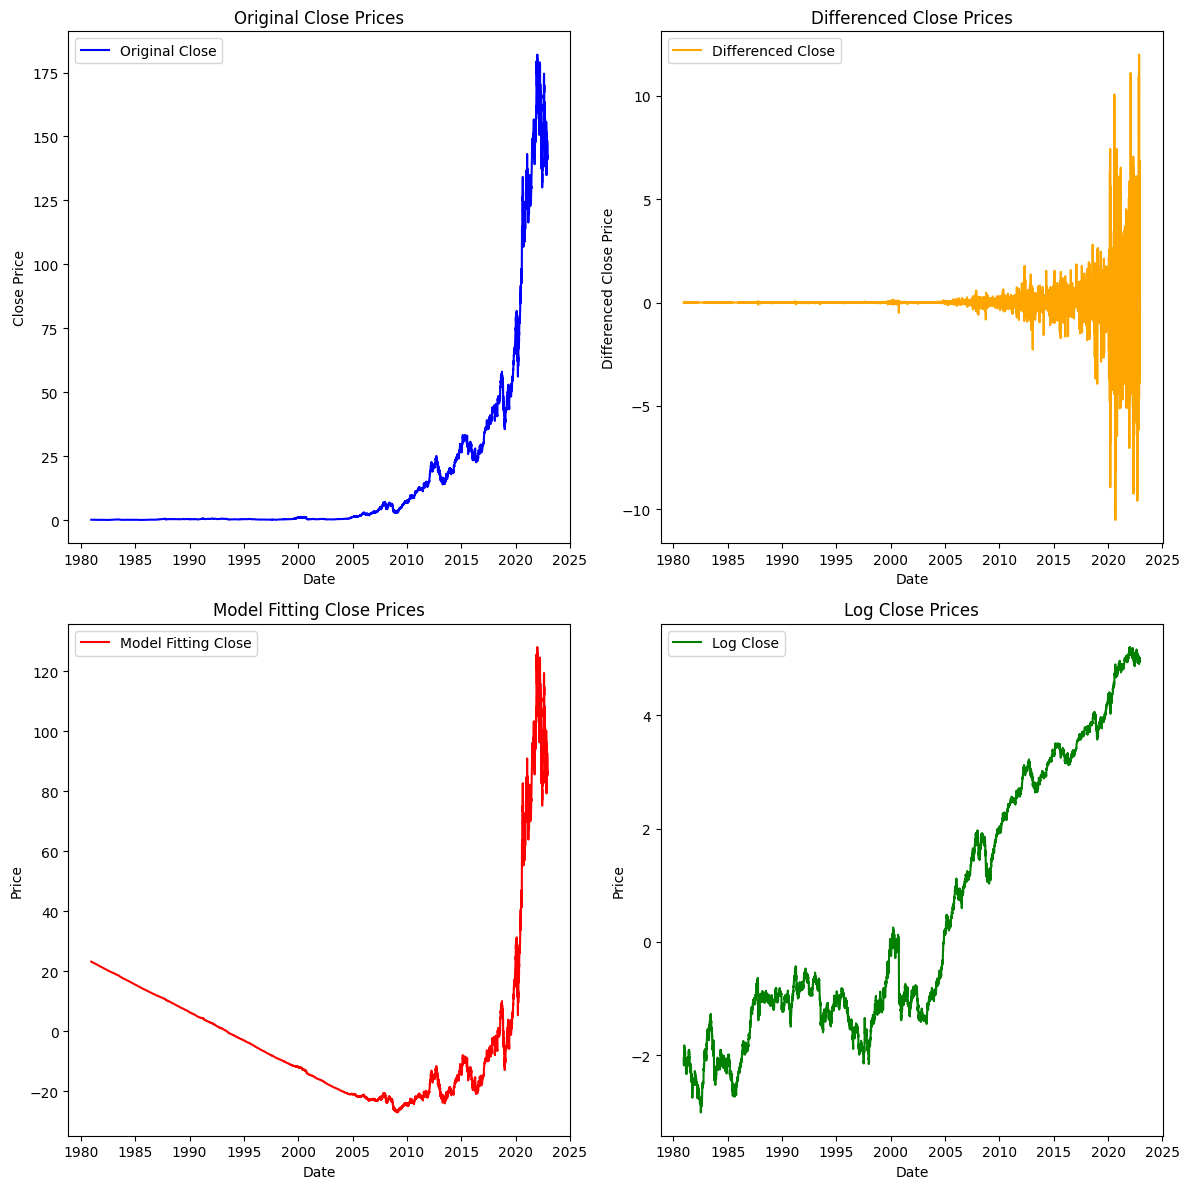

In [13]:
import matplotlib.pyplot as plt

# Plot the original 'Close' prices
plt.figure(figsize=(12, 12))  # Adjusted for larger size
plt.subplot(2, 2, 1)  # Two rows, two columns, first plot
plt.plot(df['Date'], df['Close'], label='Original Close', color='blue')
plt.title('Original Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot the differenced 'Close' prices
plt.subplot(2, 2, 2)  # Two rows, two columns, second plot
plt.plot(df['Date'], df['close_diff'], label='Differenced Close', color='orange')
plt.title('Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()

# Plot the 'Model Fitting Close' prices (assuming this column exists in df)
plt.subplot(2, 2, 3)  # Two rows, two columns, third plot
plt.plot(df['Date'], df['close_detrend'], label='Model Fitting Close', color='red')
plt.title('Model Fitting Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot the 'Log Close' prices (assuming this column exists in df)
plt.subplot(2, 2, 4)  # Two rows, two columns, fourth plot
plt.plot(df['Date'], df['close_log'], label='Log Close', color='green')
plt.title('Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()  # Adjusts the plots to fit visually better
plt.show()


### Check Stationarity on new Close Columns

In [14]:
def ADF_check(column):
    close_prices = df[column]
    result = adfuller(close_prices.dropna())  # Drop NA values if present
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [15]:
df['close_diff'].dropna(inplace=True)
ADF_check('close_diff')

ADF Statistic: -17.801984
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [16]:
ADF_check('close_log')

ADF Statistic: 0.340529
p-value: 0.979129
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [17]:
ADF_check('close_detrend')

ADF Statistic: 0.599443
p-value: 0.987602
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Apply Fractional Differencing

In [7]:
from fracdiff.sklearn import FracdiffStat

In [10]:

# Initialize the FracdiffStat object
fd = FracdiffStat()

# Apply fractional differencing
fracdiff_series = fd.fit_transform(df[['Close']].values)

# Convert the result back to a DataFrame for easier handling
fracdiff_df = pd.DataFrame(fracdiff_series, columns=['FracDiffClose'])

# Combine with the original data for comparison
df = pd.concat([df, fracdiff_df], axis=1)

# Display the first few rows to check
print(df.head())

        Date       Low      Open     Volume      High     Close  \
0 1980-12-12  0.128348  0.128348  469033600  0.128906  0.128348   
1 1980-12-15  0.121652  0.122210  175884800  0.122210  0.121652   
2 1980-12-16  0.112723  0.113281  105728000  0.113281  0.112723   
3 1980-12-17  0.115513  0.115513   86441600  0.116071  0.115513   
4 1980-12-18  0.118862  0.118862   73449600  0.119420  0.118862   

   Adjusted Close  FracDiffClose  FracDiffClose  
0        0.099874       0.128348       0.128348  
1        0.094663       0.009348       0.009348  
2        0.087715      -0.000742      -0.000742  
3        0.089886       0.007595       0.007595  
4        0.092492       0.007730       0.007730  


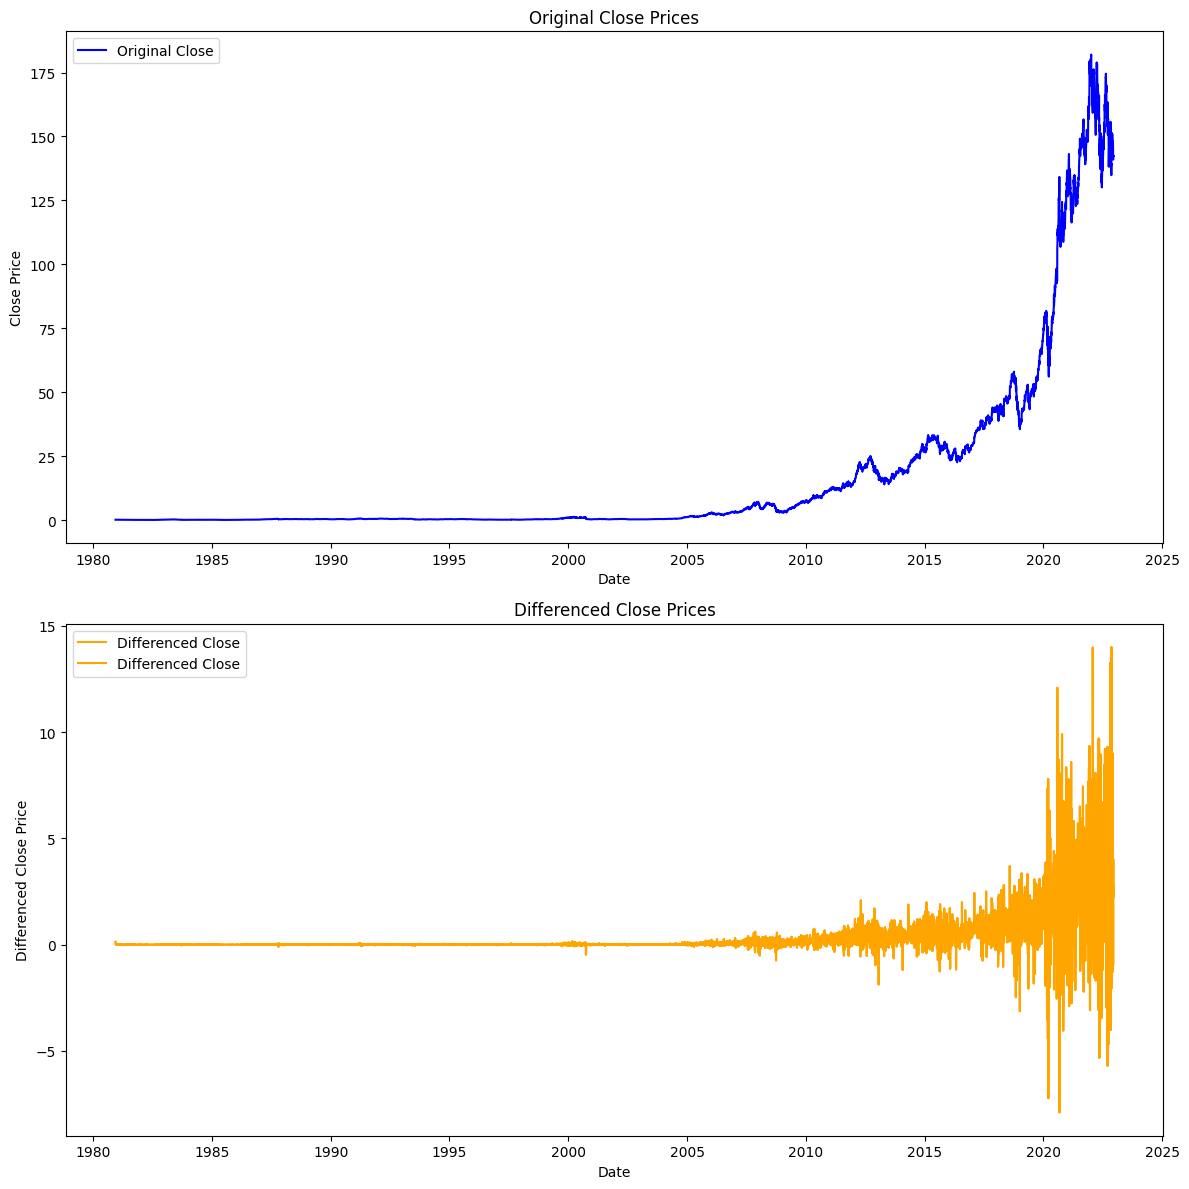

In [13]:
plt.figure(figsize=(12, 12))  # Adjusted for larger size
plt.subplot(2, 1, 1)  # Two rows, two columns, first plot
plt.plot(df['Date'], df['Close'], label='Original Close', color='blue')
plt.title('Original Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot the differenced 'Close' prices
plt.subplot(2, 1, 2)  # Two rows, two columns, second plot
plt.plot(df['Date'], df['FracDiffClose'], label='Differenced Close', color='orange')
plt.title('Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()

plt.tight_layout()  # Adjusts the plots to fit visually better
plt.show()

In [26]:
frac_diff_close_array = df['FracDiffClose'].dropna().to_numpy().flatten()

# Now apply the ADF test
result = adfuller(frac_diff_close_array)

# Output the results
adf_statistic, p_value, used_lag, n_obs, critical_values, ic_best = result
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

ADF Statistic: -4.5197721347905375
p-value: 0.0001810813021858461
Critical Values:
	1%: -3.430659473074367
	5%: -2.8616767766261213
	10%: -2.566842802390578
